#Introduction
<hr>
We are going to develop an AI Model which will detect the emotion of a person by recognizing the gesture of his face.<br>

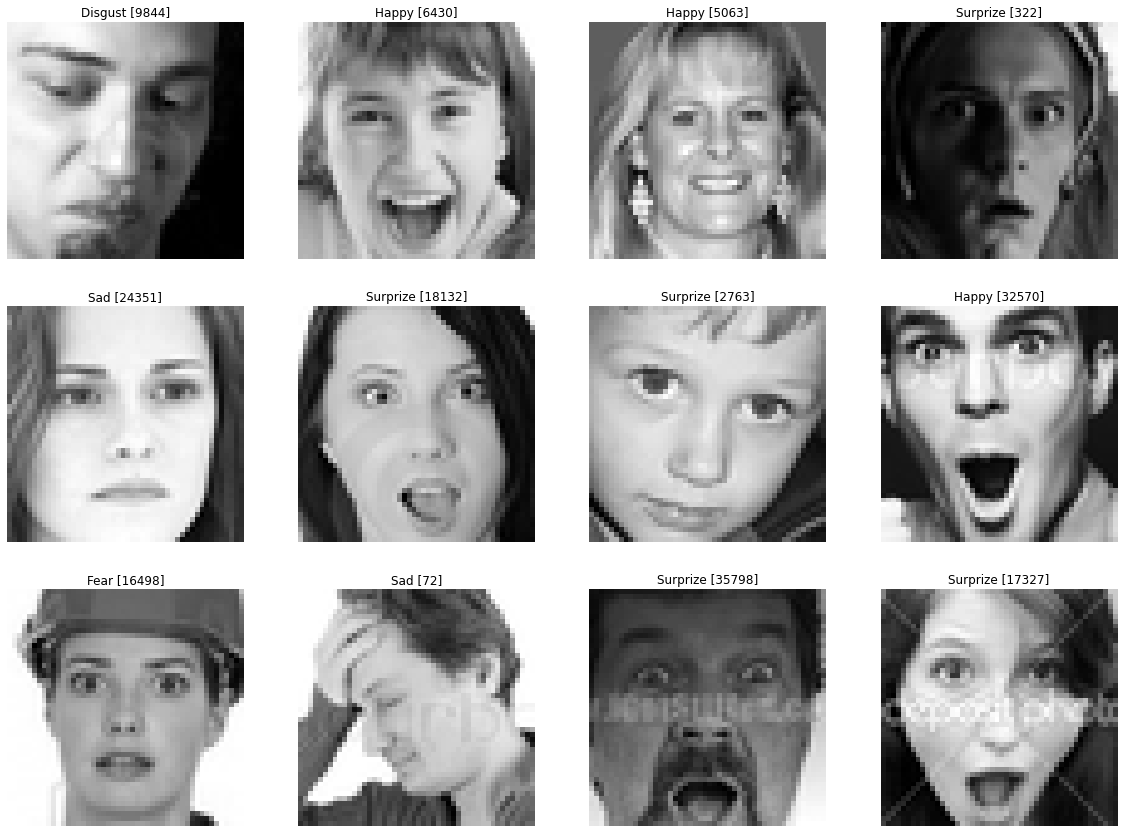

Here we are going to use Convolutional Neural Networks for the model training and OpenCV for the webcam and model deployement.
For model training we are referring to an open source dataset <i>fer2013</i> from kaggle.

#Setting up kaggle api for getting the datset
<hr>

####For that you can go to kaggle.com-> your profile-> Account-> Create New API Token
Then upload the kaggle.json file in google collab and then run the below commands

In [1]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory 
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Put the name of the dataset that you want to use and then unzip the dataset**

In [2]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

 98% 95.0M/96.6M [00:03<00:00, 52.1MB/s]
100% 96.6M/96.6M [00:03<00:00, 31.8MB/s]


In [3]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


#Importing necesaary files
<hr>



In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [5]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

#Exploraotry Data Analysis
<hr>



In [6]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [7]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [8]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


##No of images present in dataset corresponding to training testing and validation part

In [9]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


##Visualizing images from the dataset

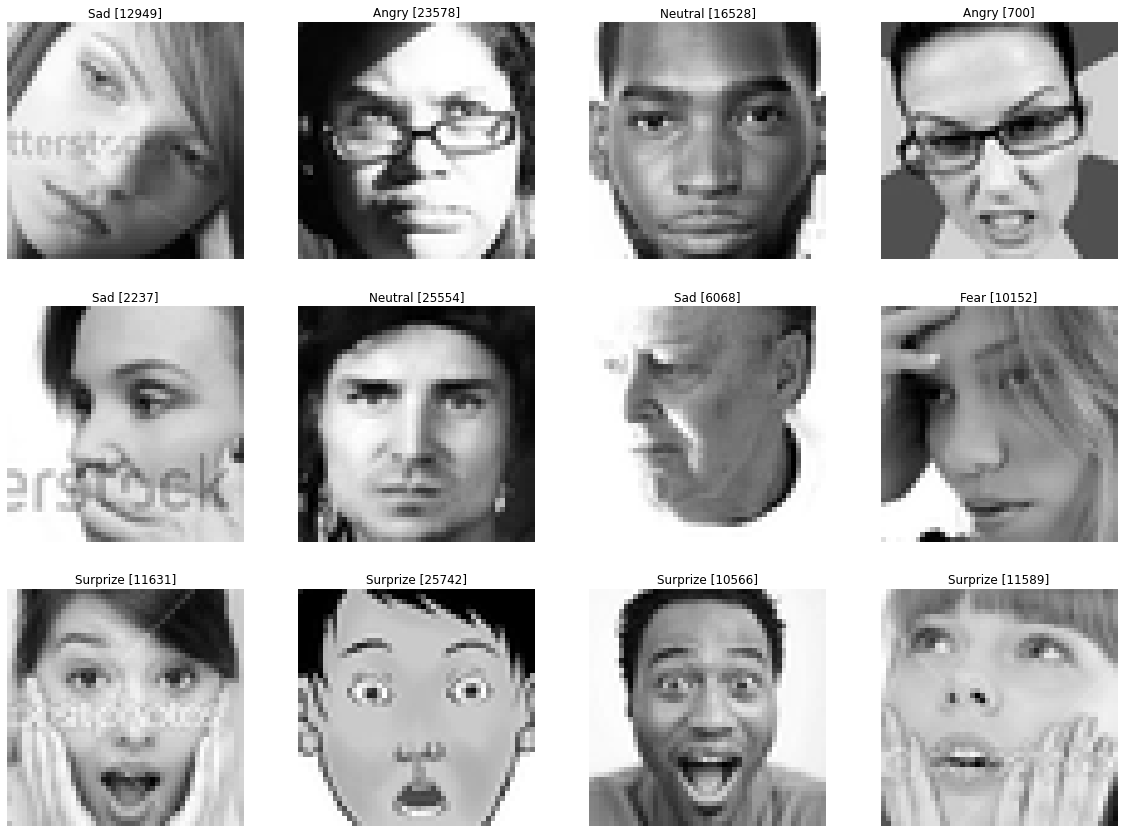

In [10]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [11]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [12]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

**As you can see above we have to change the shape of the images to train them as the above shape is not compatible**

In [13]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7) 
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

#Defining Model Archietechture

VGG16

In [14]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [29]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_pad1 (ZeroPadding2D)  (None, 50, 50, 1)        0         
                                                                 
 block1_l1 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 block1_pad2 (ZeroPadding2D)  (None, 50, 50, 64)       0         
                                                                 
 block1_l2 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 block2_pad1 (ZeroPadding2D)  (None, 26, 26, 64)       0         
                                                                 
 block2_l1 (Conv2D)          (None, 24, 24, 128)      

In [19]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_val,y_val)
)

Epoch 1/30
898/898 [==============================] - 52s 47ms/step - loss: 1.8246 - accuracy: 0.2474 - val_loss: 1.8098 - val_accuracy: 0.2494
Epoch 2/30
898/898 [==============================] - 43s 48ms/step - loss: 1.7731 - accuracy: 0.2729 - val_loss: 1.7334 - val_accuracy: 0.2934
Epoch 3/30
898/898 [==============================] - 45s 50ms/step - loss: 1.5968 - accuracy: 0.3747 - val_loss: 1.5405 - val_accuracy: 0.4093
Epoch 4/30
898/898 [==============================] - 45s 51ms/step - loss: 1.4664 - accuracy: 0.4289 - val_loss: 1.3883 - val_accuracy: 0.4731
Epoch 5/30
898/898 [==============================] - 46s 51ms/step - loss: 1.3564 - accuracy: 0.4788 - val_loss: 1.3964 - val_accuracy: 0.4620
Epoch 6/30
898/898 [==============================] - 46s 51ms/step - loss: 1.2603 - accuracy: 0.5184 - val_loss: 1.2935 - val_accuracy: 0.5077
Epoch 7/30
898/898 [==============================] - 45s 50ms/step - loss: 1.1746 - accuracy: 0.5549 - val_loss: 1.2872 - val_accuracy:

#Model Evaluation
<hr>

Lets see the output resutls <br>
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

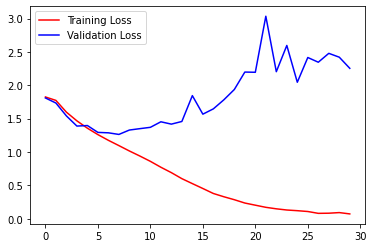

In [20]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [21]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 2s 14ms/step


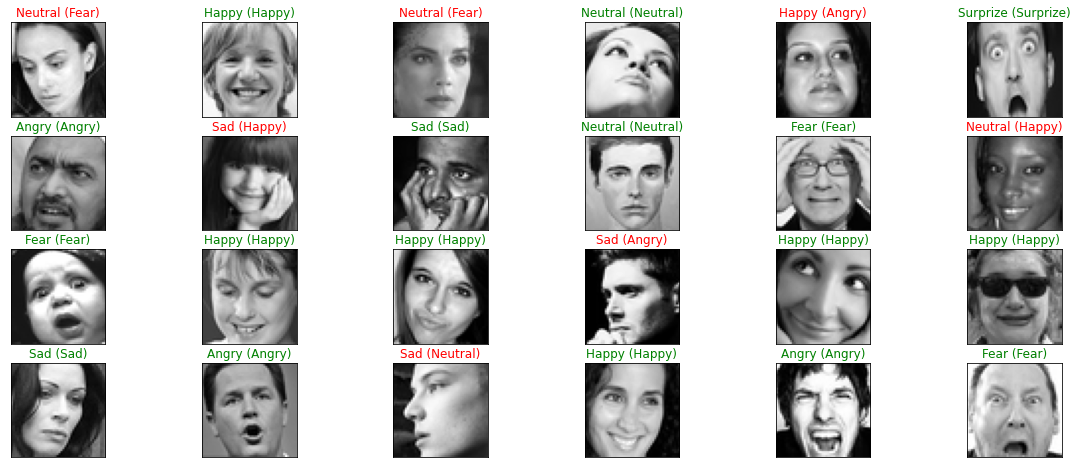

In [22]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]
      
      ax.set_title("{} ({})".format((predict_index), 
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [23]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

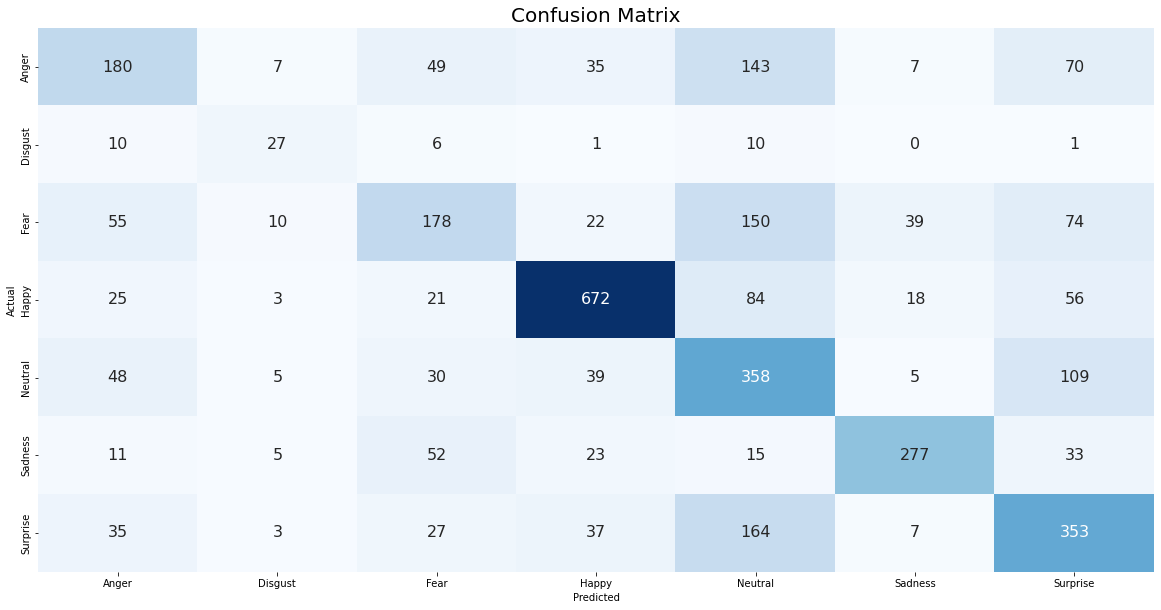

In [24]:
conf_mat(y_test,y_pred)

In [25]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.495     0.367     0.421       491
           1      0.450     0.491     0.470        55
           2      0.490     0.337     0.400       528
           3      0.811     0.765     0.787       879
           4      0.387     0.603     0.472       594
           5      0.785     0.666     0.720       416
           6      0.507     0.564     0.534       626

    accuracy                          0.570      3589
   macro avg      0.561     0.542     0.543      3589
weighted avg      0.589     0.570     0.571      3589



In [27]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)


898/898 [==============================] - 14s 15ms/step - loss: 0.3589 - accuracy: 0.8892
On Training Data [0.3589032292366028, 0.8892333507537842]
113/113 [==============================] - 2s 16ms/step - loss: 2.2538 - accuracy: 0.5715
On Validation Data [2.2537968158721924, 0.5714683532714844]
113/113 [==============================] - 2s 16ms/step - loss: 2.2188 - accuracy: 0.5698
On Test Data [2.2188222408294678, 0.569796621799469]


#Fine Tuning
<hr>

Let's try to improve the model

1. Changing epoch, learning rate and batch size

In [ ]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    validation_data=(X_val,y_val)
)


Epoch 1/60
449/449 [==============================] - 33s 71ms/step - loss: 1.8572 - accuracy: 0.2399 - val_loss: 1.8184 - val_accuracy: 0.2494
Epoch 2/60
449/449 [==============================] - 32s 72ms/step - loss: 1.8294 - accuracy: 0.2440 - val_loss: 1.8135 - val_accuracy: 0.2494
Epoch 3/60
449/449 [==============================] - 32s 72ms/step - loss: 1.8206 - accuracy: 0.2482 - val_loss: 1.8114 - val_accuracy: 0.2494
Epoch 4/60
449/449 [==============================] - 33s 74ms/step - loss: 1.8164 - accuracy: 0.2492 - val_loss: 1.8046 - val_accuracy: 0.2494
Epoch 5/60
449/449 [==============================] - 33s 75ms/step - loss: 1.8115 - accuracy: 0.2495 - val_loss: 1.7985 - val_accuracy: 0.2494
Epoch 6/60
449/449 [==============================] - 34s 75ms/step - loss: 1.8065 - accuracy: 0.2515 - val_loss: 1.7929 - val_accuracy: 0.2494
Epoch 7/60
449/449 [==============================] - 34s 76ms/step - loss: 1.7964 - accuracy: 0.2550 - val_loss: 1.7775 - val_accuracy:

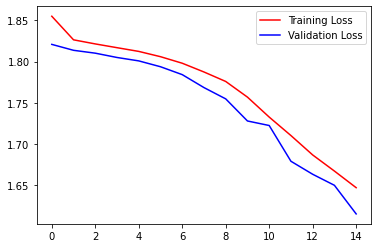

In [18]:
loss_plot(history)

In [19]:
# loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)

898/898 [==============================] - 14s 15ms/step - loss: 1.6055 - accuracy: 0.3773
On Training Data [1.6055103540420532, 0.37733811140060425]
113/113 [==============================] - 2s 15ms/step - loss: 1.6151 - accuracy: 0.3901
On Validation Data [1.615134835243225, 0.3900808095932007]
113/113 [==============================] - 2s 15ms/step - loss: 1.6145 - accuracy: 0.3781
On Test Data [1.6144851446151733, 0.3780997395515442]


113/113 [==============================] - 2s 13ms/step


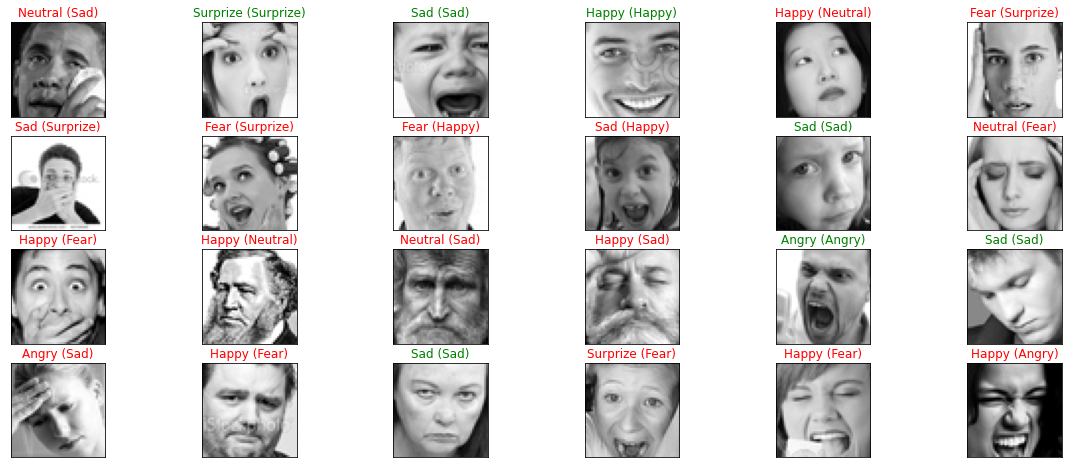

In [21]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

check_images(X_test,y_pred,emotions)

In [22]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.308     0.122     0.175       491
           1      0.000     0.000     0.000        55
           2      0.179     0.038     0.062       528
           3      0.450     0.761     0.565       879
           4      0.314     0.300     0.307       594
           5      0.427     0.440     0.433       416
           6      0.310     0.395     0.347       626

    accuracy                          0.378      3589
   macro avg      0.284     0.294     0.270      3589
weighted avg      0.334     0.378     0.333      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Trying other Arch

Model is not giving good results on validation data as there are very less images of certain classes than other ones

##lets try pretrained vgg16 arch

In [ ]:
model2 = vgg16.VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=(48,48,3)
                     )
for layer in model2.layers:
  layer.trainable = False

model2.summary()

#Hence the VGG16 model takes 3 channels or we can say rgb images as an input so we have 
# to change our input from one channel to 3 channles

In [ ]:
# changing the image dims
X_train1 = np.repeat(X_train, 3, -1)
X_test1 = np.repeat(X_test, 3, -1)
X_val1 = np.repeat(X_val, 3, -1)

X_train1.shape,X_val1.shape,X_test1.shape

In [ ]:
def layer_adder(bottom_model,num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model

In [ ]:
FC_Head = layer_adder(model2,7)
model2 =  Model(inputs = model2.input,outputs = FC_Head)

model2.summary()

In [ ]:
checkpoint = ModelCheckpoint("emotion_detection.h15",
                             monitor = "val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1
                             )
early_stopping = EarlyStopping(monitor = "val_loss",
                               min_delta=0,
                               patience=3,
                               restore_best_weights=True)

callbacks=[early_stopping,checkpoint]

model2.compile(loss = "categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])


In [ ]:
history1 = model2.fit(
    X_train1,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks = callbacks,
    validation_data=(X_val1,y_val)
)

In [ ]:
loss_plot(history1)

still it does not affect the validation performance.
lets try to increase the validation data and try again


In [ ]:
X_val_new = np.concatenate((X_val1, X_test1), axis=0)
y_val_new = np.concatenate((y_val, y_test), axis=0)

X_val_new.shape, y_val_new.shape

((7178, 48, 48, 3), (7178, 7))

In [ ]:
history2 = model2.fit(
    X_train1,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks = callbacks,
    validation_data=(X_val_new,y_val_new)
)

Epoch 1/30
895/898 [============================>.] - ETA: 0s - loss: 1.4423 - accuracy: 0.4486
Epoch 1: val_loss improved from 1.55738 to 1.54651, saving model to emotion_detection.h15


898/898 [==============================] - 23s 26ms/step - loss: 1.4418 - accuracy: 0.4487 - val_loss: 1.5465 - val_accuracy: 0.4171
Epoch 2/30
895/898 [============================>.] - ETA: 0s - loss: 1.3449 - accuracy: 0.4902
Epoch 2: val_loss did not improve from 1.54651
898/898 [==============================] - 22s 24ms/step - loss: 1.3445 - accuracy: 0.4905 - val_loss: 1.6021 - val_accuracy: 0.4285
Epoch 3/30
895/898 [============================>.] - ETA: 0s - loss: 1.2458 - accuracy: 0.5288
Epoch 3: val_loss did not improve from 1.54651
898/898 [==============================] - 19s 22ms/step - loss: 1.2455 - accuracy: 0.5291 - val_loss: 1.6989 - val_accuracy: 0.4181
Epoch 4/30
895/898 [============================>.] - ETA: 0s - loss: 1.1525 - accuracy: 0.5724
Epoch 4: val_loss did not improve from 1.54651
898/898 [==============================] - 19s 22ms/step - loss: 1.1525 - accuracy: 0.5724 - val_loss: 1.7588 - val_accuracy: 0.4354


In [ ]:
loss_plot(history2)

In [ ]:
preds = model2.predict(X_test1)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 2s 12ms/step


In [ ]:
check_images(X_test,y_pred,emotions)

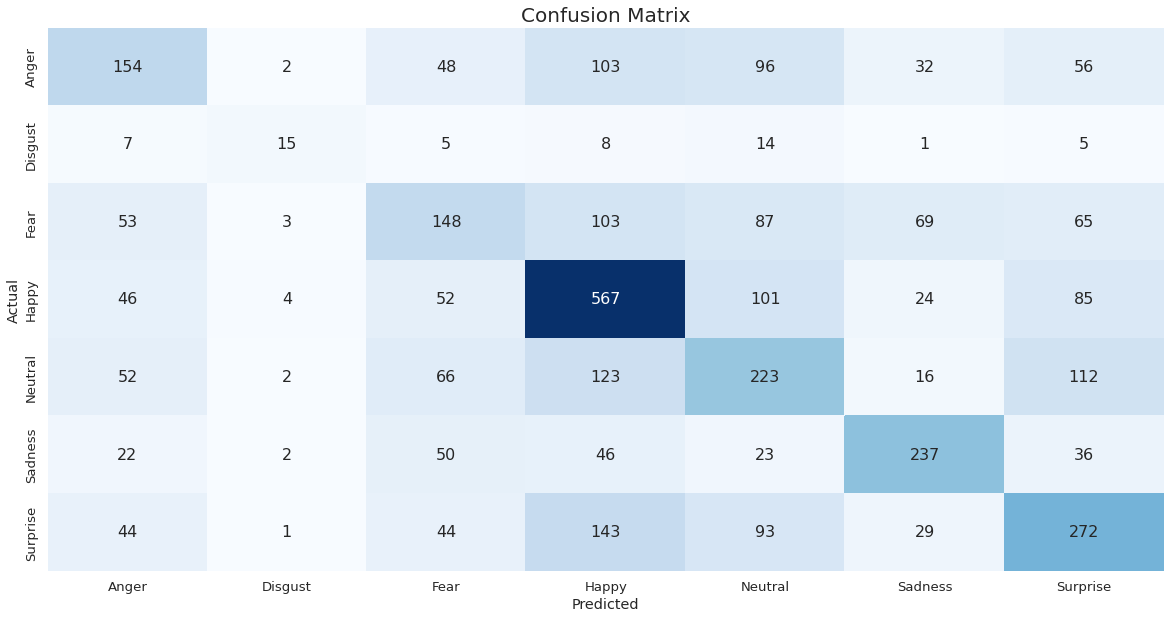

In [ ]:
conf_mat(y_test,y_pred)

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.407     0.314     0.354       491
           1      0.517     0.273     0.357        55
           2      0.358     0.280     0.315       528
           3      0.519     0.645     0.575       879
           4      0.350     0.375     0.362       594
           5      0.581     0.570     0.575       416
           6      0.431     0.435     0.433       626

    accuracy                          0.450      3589
   macro avg      0.452     0.413     0.425      3589
weighted avg      0.444     0.450     0.443      3589



#Model Saving

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

#Deploying model using OpenCV
<hr>

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

##loading model arch and weights

In [ ]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

##Open CV code for webcam and prediction

In [ ]:
cap=cv2.VideoCapture(0) # start webcam
while True:
    (valid,test_image)=cap.read() #reading image from video frame
    if not valid: #if not getting frames then exit
        break

    gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale


    faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
    for (x,y,w,h) in faces_detected: #cordinates of deteced faces
        cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
        roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
        roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
        image_pixels = img_to_array(roi_gray) #converting image to array
        image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
        # image_pixels /= 255


        predictions = model.predict(image_pixels) #model prediction
        max_index = np.argmax(predictions[0]) #getting emotion index

        emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        emotion_prediction = emotion_detection[max_index]


        cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
    #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)  


        resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
        cv2.imshow('Emotion Dectector',resize_image)
        if cv2.waitKey(10) == ord('b'):
            break